In [1]:
DEVICE="cuda"

import numpy as np
import sklearn.metrics
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from transformers import AutoModel, AutoImageProcessor, PreTrainedModel, PretrainedConfig

In [2]:
class ImageMultiRegressionConfig(PretrainedConfig):
    def __init__(
        self,
        output_size=3,
        init_checkpoint=None,
        **kwargs,
    ):
        self.output_size=output_size
        self.init_checkpoint=init_checkpoint
        super().__init__(**kwargs)


class ImageMultiRegressionModel(PreTrainedModel):
    config_class=ImageMultiRegressionConfig
    def __init__(self, config, loss=nn.MSELoss()):
        super().__init__(config)
        
        self.inner_model = AutoModel.from_pretrained(config.init_checkpoint)
        self.classifier = nn.Linear(self.inner_model.config.hidden_size, config.output_size)
        self.loss=loss
    
    def forward(self, pixel_values, labels=None):
        outputs = self.inner_model(pixel_values=pixel_values)
        cls_output = outputs.last_hidden_state[:, 0, :]  # image embedding
        values = self.classifier(cls_output)
        loss = None
        if labels is not None:
            loss = self.loss(values.view(-1), labels.view(-1))
        return (loss, values) if loss is not None else values

In [3]:
from datasets import load_from_disk
dataset=load_from_disk("./data/dataset/")
dataset["train"].set_format("torch")
dataset["test"].set_format("torch")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms.v2 as transforms
import torch

_train_transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    transforms.RandomRotation(degrees=20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=(256,256), scale=(.6,1.0), antialias=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def train_transform(ex):
    if "image" in ex:
        ex["pixel_values"]=[_train_transform(image) for image in ex["image"]]
    return ex
    
_test_transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    transforms.Resize(size=(256,256)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def test_transform(ex):
    if "image" in ex:
        ex["pixel_values"]=[_test_transform(image) for image in ex["image"]]
    return ex

dataset["train"].set_transform(train_transform)
dataset["test"].set_transform(test_transform)

In [4]:
#gather training data statistics

In [5]:
t1=torch.tensor(dataset["train"]["light_level"])
t2=torch.tensor(dataset["train"]["fume_strength"])
t3=torch.tensor(dataset["train"]["explosion_strength"])
ty=torch.tensor(dataset["train"]["class"])
T=torch.stack([t1,t2,t3], dim=1)

In [6]:
#gather target statistics

In [72]:
y1=torch.tensor(dataset["test"]["light_level"])
y2=torch.tensor(dataset["test"]["fume_strength"])
y3=torch.tensor(dataset["test"]["explosion_strength"])
yy=dataset["test"].features["class"].int2str(torch.tensor(dataset["test"]["class"]))
Y=torch.stack([y1,y2,y3], dim=1)

In [74]:
# out of sample R score
# https://stats.stackexchange.com/questions/228540/how-to-calculate-out-of-sample-r-squared/492581#492581
# https://arxiv.org/pdf/2302.05131
def oosR(MST, MSE): 
    return 1-MSE/MST

In [75]:
null_MSE=0

In [76]:
#calculate standard metrics for regression predictors
def compute_metrics_reg(x,y):
    MSE=sklearn.metrics.mean_squared_error(x, y)
    return {"MSE":MSE,
           "MAE":sklearn.metrics.mean_absolute_error(x,y),
           "R2_test":sklearn.metrics.r2_score(x,y),
           "oosR2":0 if null_MSE==0 else oosR(null_MSE,MSE),
           }

In [77]:
#calculate standard metrics for regression predictors
def compute_metrics_class(x,y):
    report=sklearn.metrics.classification_report(x,y, output_dict=True)
    matrix=sklearn.metrics.confusion_matrix(x,y)
    return report, matrix

In [78]:
def reg_to_class(x): #[b, 3]
    t=np.full(x.shape[0], "INA")
    t_f=np.full(x.shape[0], "FUM")
    t_e=np.full(x.shape[0], "EXP")
    t_ef=np.full(x.shape[0], "EXP+FUM")
    t=np.where((x[:,1]>.75) & (x[:,2]>.1),t_ef,t)
    t=np.where((x[:,1]>.75) & (x[:,2]<=.1),t_f,t)
    t=np.where((x[:,1]<=.75) & (x[:,2]>.1),t_e,t)
    
    return t

In [125]:
def compute_metrics_class_reg(x,y):
    nx=reg_to_class(x)
    return compute_metrics_class(list(nx), list(y))

In [80]:
compute_metrics_class_reg(Y, yy)

({'EXP': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 52.0},
  'EXP+FUM': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 699.0},
  'FUM': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 649.0},
  'INA': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 491.0},
  'accuracy': 1.0,
  'macro avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 1891.0},
  'weighted avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 1891.0}},
 array([[ 52,   0,   0,   0],
        [  0, 699,   0,   0],
        [  0,   0, 649,   0],
        [  0,   0,   0, 491]], dtype=int64))

In [12]:
# baseline: always predict the mean

In [13]:
T_mean=T.mean(dim=0)

In [14]:
T_mean_only = T_mean.repeat(Y.shape[0],1)

In [15]:
T_mean_only.shape, Y.shape

(torch.Size([1891, 3]), torch.Size([1891, 3]))

In [16]:
T_mean_only[1]

tensor([0.9057, 0.7516, 0.3702])

In [82]:
mean_metrics_reg = compute_metrics_reg(T_mean_only, Y); mean_metrics

{'MSE': 0.14325829,
 'MAE': 0.31039932,
 'R2_test': -5585542918.205559,
 'oosR2': 0}

In [83]:
mean_metrics_class = compute_metrics_class_reg(T_mean_only, yy)

C:\Users\mirlu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mirlu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mirlu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [84]:
null_MSE=mean_metrics_reg["MSE"]

In [85]:
# baseline: always predict the median

In [86]:
T_median=T.median(dim=0).values

In [87]:
T_median_only = T_median.repeat(Y.shape[0],1)

In [88]:
T_median_only.shape, Y.shape

(torch.Size([1891, 3]), torch.Size([1891, 3]))

In [89]:
T_median_only[1]

tensor([1., 1., 0.])

In [90]:
median_metrics_reg = compute_metrics_reg(T_median_only, Y); median_metrics

{'MSE': 0.21269357,
 'MAE': 0.23851593,
 'R2_test': 0.0,
 'oosR2': -0.484686017036438}

In [91]:
median_metrics_class = compute_metrics_class_reg(T_median_only, yy)

C:\Users\mirlu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mirlu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mirlu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [92]:
median_metrics_class

({'EXP': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
  'EXP+FUM': {'precision': 0.0,
   'recall': 0.0,
   'f1-score': 0.0,
   'support': 0.0},
  'FUM': {'precision': 1.0,
   'recall': 0.343204653622422,
   'f1-score': 0.511023622047244,
   'support': 1891.0},
  'INA': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
  'accuracy': 0.343204653622422,
  'macro avg': {'precision': 0.25,
   'recall': 0.0858011634056055,
   'f1-score': 0.127755905511811,
   'support': 1891.0},
  'weighted avg': {'precision': 1.0,
   'recall': 0.343204653622422,
   'f1-score': 0.511023622047244,
   'support': 1891.0}},
 array([[  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [ 52, 699, 649, 491],
        [  0,   0,   0,   0]], dtype=int64))

In [28]:
from fastprogress import progress_bar as pb

In [40]:
def evaluate_reg(model):
    outputs=[]
    for batch in pb(dataset["test"]):
        output=model(batch["pixel_values"][None,:,:,:].to(DEVICE)).cpu().detach()
        outputs.append(output)
    return torch.stack(outputs).squeeze()

In [46]:
# results: regression models

reg_model_paths=[
    "mirluvams/swinv2-tiny-patch4-window16-256-popocatepetl", 
    "mirluvams/swinv2-base-patch4-window16-256-popocatepetl", 
]
reg_results=[evaluate_reg(ImageMultiRegressionModel.from_pretrained(model).to(DEVICE)) for model in reg_model_paths]

config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

In [94]:
reg_scores_reg=[compute_metrics_reg(results, Y) for results in reg_results]

In [122]:
reg_results[0]

tensor([[ 0.6602,  0.9563,  0.8725],
        [ 1.0020,  1.0035, -0.0060],
        [ 0.9492,  0.9771,  0.9789],
        ...,
        [ 0.9898,  0.9101, -0.0061],
        [ 0.9705,  0.9997,  1.0065],
        [ 0.9892,  1.0209, -0.0290]])

In [126]:
reg_scores_class=[compute_metrics_class_reg(results, yy) for results in reg_results]

In [52]:
reg_scores[0]

{'MSE': 0.051310107,
 'MAE': 0.107360184,
 'R2_test': 0.39072864974434873,
 'oosR2': 0.6418349742889404}

In [127]:
reg_scores_class[0]

({'EXP': {'precision': 0.6153846153846154,
   'recall': 0.2831858407079646,
   'f1-score': 0.3878787878787879,
   'support': 113.0},
  'EXP+FUM': {'precision': 0.871244635193133,
   'recall': 0.87,
   'f1-score': 0.8706218727662616,
   'support': 700.0},
  'FUM': {'precision': 0.7935285053929122,
   'recall': 0.8401305057096248,
   'f1-score': 0.8161648177496038,
   'support': 613.0},
  'INA': {'precision': 0.7576374745417516,
   'recall': 0.8,
   'f1-score': 0.7782426778242678,
   'support': 465.0},
  'accuracy': 0.8080380750925437,
  'macro avg': {'precision': 0.7594488076281031,
   'recall': 0.6983290866043974,
   'f1-score': 0.7132270390547303,
   'support': 1891.0},
  'weighted avg': {'precision': 0.8028260738452798,
   'recall': 0.8080380750925437,
   'f1-score': 0.8014053370890946,
   'support': 1891.0}},
 array([[ 32,  47,  17,  17],
        [ 18, 609,  38,  35],
        [  0,  31, 515,  67],
        [  2,  12,  79, 372]], dtype=int64))

In [ ]:
# results: regression models translated to classification

In [ ]:
# results: classification models 

In [ ]:
model=ImageMultiRegressionModel.from_pretrained(reg_model_paths[0])

In [ ]:
def display(idx):
    row=dataset["test"][idx]
    print(row["old_class"], row["class"])
    print(row["light_level"], row["fume_strength"], row["explosion_strength"])
    print(model(row["pixel_values"]))
    return row["image"]

4 4
0.20000000298023224 0.800000011920929 0.800000011920929


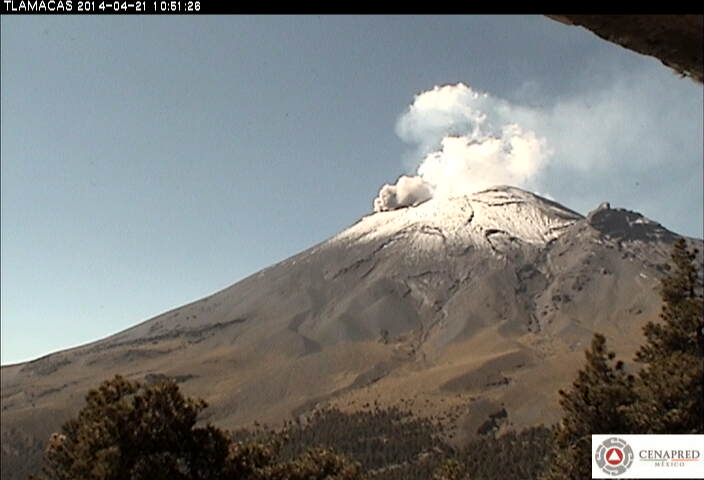

In [132]:
display(0)